# Imports

In [4]:
import pandas as pd  
import numpy as np
from skimpy import skim

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectKBest, f_classif

from xgboost import XGBClassifier

from multiprocessing import pool

from keras.models import Sequential
from keras.layers import Dense, Dropout, Normalization
from keras.losses import BinaryCrossentropy

import optuna
import pickle

# Necessary functions

In [23]:
def run_RandomForest(df_train_valid, df_test):
    
    X_train, X_test, y_train, y_test = train_test_split(df_train_valid.drop('shipment_issue',axis=1), df_train_valid['shipment_issue'], test_size=0.2, random_state=42, stratify=df_train_valid['shipment_issue'])
    selected_features = ['carrier_Carrier_B', 'carrier_Carrier_C', 'weather_conditions', 'package_type', 'location']
    
    under_sampler = RandomUnderSampler(sampling_strategy=.5, random_state=42)
    X_new, y_new = under_sampler.fit_resample(df_train_valid.drop('shipment_issue',axis=1), df_train_valid['shipment_issue'])
    df_train_valid = pd.concat([X_new, y_new],axis=1)
    

    k_strat = StratifiedKFold(n_splits=5, shuffle=False)
    folds = k_strat.split(df_train_valid.drop('shipment_issue',axis=1), df_train_valid['shipment_issue'])
    acc = []
    baseline_acc = []
    
    for train, test in folds:
        
        X_train, X_test = df_train_valid.drop('shipment_issue',axis=1).iloc[train], df_train_valid.drop('shipment_issue',axis=1).iloc[test]
        y_train, y_test = df_train_valid['shipment_issue'].values[train], df_train_valid['shipment_issue'].values[test]
        X_train = X_train[['weather_conditions', 'package_type', 'location']]
        X_test = X_test[['weather_conditions', 'package_type', 'location']]
        
        def objective(trial):
            
            n_estimators = trial.suggest_int("n_estimators", 10, 200)
            max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
            min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
            min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

            # Create and train the model
            model = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                random_state=42,
            )
            model.fit(X_train, y_train)
    
            y_preds = model.predict(X_test)
            
            return roc_auc_score(y_test, y_preds)
        
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=50)
        best_params = study.best_params
        
        model = RandomForestClassifier(**best_params)
        model.fit(X_train, y_train)
        y_preds = model.predict(X_test)
        y_preds_baseline = np.tile(0, len(y_test))
        
        accuracy_score_baseline = roc_auc_score(y_test, y_preds_baseline)
        accuracy_score_LR = roc_auc_score(y_test, y_preds)
        acc.append(accuracy_score_LR)
        baseline_acc.append(accuracy_score_baseline)
    
    print(np.average(acc), np.average(baseline_acc))
    
    X = df_train_valid.drop('shipment_issue', axis=1)[selected_features]
    y = df_train_valid['shipment_issue']
    model.fit(X, y)
    
    X_test = df_test.drop('shipment_issue', axis=1)
    y_test = df_test['shipment_issue']
    y_test_preds = model.predict(X_test[selected_features])
    
    reporting_error = roc_auc_score(y_test, y_test_preds)
    
    info_dict = {
        'model':model,
        'baseline_accuracy':np.average(baseline_acc),
        'model_accuracy': np.average(acc),
        'reporting_error':reporting_error,
        'cols_to_use':X_test[selected_features]
    }
    
    return info_dict 

def run_SVC(df_train_valid, df_test):
    
    X_train, X_test, y_train, y_test = train_test_split(df_train_valid.drop('shipment_issue',axis=1), df_train_valid['shipment_issue'], test_size=0.2, random_state=42, stratify=df_train_valid['shipment_issue'])

    under_sampler = RandomUnderSampler(sampling_strategy=.5, random_state=42)
    X_new, y_new = under_sampler.fit_resample(df_train_valid.drop('shipment_issue',axis=1), df_train_valid['shipment_issue'])
    df_train_valid = pd.concat([X_new, y_new],axis=1)
    
    k_strat = StratifiedKFold(n_splits=5, shuffle=False)
    folds = k_strat.split(df_train_valid.drop('shipment_issue',axis=1), df_train_valid['shipment_issue'])
    acc = []
    baseline_acc = []

    selected_features = ['carrier_Carrier_B', 'carrier_Carrier_C', 'weather_conditions', 'package_type', 'location', 'pop_density', 'holiday_period', 'customer_tier']
    
    for train, test in folds:
        
        X_train, X_test = df_train_valid.drop('shipment_issue',axis=1).iloc[train], df_train_valid.drop('shipment_issue',axis=1).iloc[test]
        y_train, y_test = df_train_valid['shipment_issue'].values[train], df_train_valid['shipment_issue'].values[test]
        X_train = X_train[selected_features]
        X_test = X_test[selected_features]
        
        model = SVC(kernel='rbf')
        
        model.fit(X_train, y_train)
        y_preds = model.predict(X_test)
        y_preds_baseline = np.tile(0, len(y_test))
        
        accuracy_score_baseline = roc_auc_score(y_test, y_preds_baseline)
        accuracy_score_LR = roc_auc_score(y_test, y_preds)
        acc.append(accuracy_score_LR)
        baseline_acc.append(accuracy_score_baseline)
    
    print(np.average(acc), np.average(baseline_acc))
    
    X = df_train_valid.drop('shipment_issue', axis=1)[selected_features]
    y = df_train_valid['shipment_issue']
    model.fit(X, y)
    
    X_test = df_test.drop('shipment_issue', axis=1)
    y_test = df_test['shipment_issue']
    y_test_preds = model.predict(X_test[selected_features])
    
    reporting_error = roc_auc_score(y_test, y_test_preds)
    
    info_dict = {
        'model':model,
        'baseline_accuracy':np.average(baseline_acc),
        'model_accuracy': np.average(acc),
        'reporting_error':reporting_error,
        'cols_to_use':X_test[selected_features].columns
    }
    
    return info_dict 

def export_model_and_cols(model, cols):
    with open('final_model.pkl', 'wb') as file:
        pickle.dump(model, file)
        
    col_df = pd.DataFrame({
        'idx': range(len(cols)),
        'columns': cols
    })
    
    col_df.to_csv('col_df',index=False)
    
def encode_size(x):
    
    size_dict = {
        'Medium':0,
        'Large':1
    }
    
    return size_dict[x]

def encode_shipping(x):
    
    size_dict = {
        'Expedited':0,
        'Standard':1
    }
    
    return size_dict[x]

def encode_holiday(x):
    
    size_dict = {
        'Holiday_Period_No':0,
        'Holiday_Period_Yes':1
    }
    
    return size_dict[x]

def encode_weather(x):
    
    size_dict = {
        'Clear':0,
        'Rain':1,
        'Snow':2
    }
    
    return size_dict[x]

def encode_population(x):
    
    size_dict = {
        'Low':0,
        'Medium':1,
        'High':2
    }
    
    return size_dict[x]

def encode_customer(x):
    
    size_dict = {
        'Basic':1,
        'Premium':0
    }
    
    return size_dict[x]

def encode_town(x):
    
    size_dict = {
        'Rural':0,
        'Suburban':1,
        'Urban':2
    }
    
    return size_dict[x]

# Reading data and eda

In [6]:
master_df = pd.read_csv('classification_task.csv')
master_df = master_df[master_df['distance'].isna() == False]
bad_df = master_df[master_df['shipment_issue'] == 1]

In [7]:
master_df.columns

Index(['shipment_issue', 'carrier', 'shipping_method', 'distance',
       'package_type', 'location', 'customer_tier', 'weather_conditions',
       'holiday_period', 'pop_density'],
      dtype='object')

In [8]:
for col in master_df.columns:
    if col!= 'distance':
        print(pd.value_counts(master_df[col], normalize=True))
        print(pd.value_counts(bad_df[col], normalize=True))
        print()

shipment_issue
0    0.907173
1    0.092827
Name: proportion, dtype: float64
shipment_issue
1    1.0
Name: proportion, dtype: float64

carrier
Carrier_A    0.612763
Carrier_B    0.239018
Carrier_C    0.148220
Name: proportion, dtype: float64
carrier
Carrier_A    0.781421
Carrier_B    0.160656
Carrier_C    0.057923
Name: proportion, dtype: float64

shipping_method
Standard     0.695242
Expedited    0.304758
Name: proportion, dtype: float64
shipping_method
Standard     0.672131
Expedited    0.327869
Name: proportion, dtype: float64

package_type
Medium    0.502181
Large     0.497819
Name: proportion, dtype: float64
package_type
Large     0.580328
Medium    0.419672
Name: proportion, dtype: float64

location
Suburban    0.338845
Urban       0.333063
Rural       0.328092
Name: proportion, dtype: float64
location
Urban       0.499454
Suburban    0.301639
Rural       0.198907
Name: proportion, dtype: float64

customer_tier
Basic      0.799432
Premium    0.200568
Name: proportion, dtype: float

/var/folders/k_/y5wzmsx1483f9z9t9tjtdj1m0000gn/T/ipykernel_89138/2300847994.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(master_df[col], normalize=True))
/var/folders/k_/y5wzmsx1483f9z9t9tjtdj1m0000gn/T/ipykernel_89138/2300847994.py:4: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(bad_df[col], normalize=True))
/var/folders/k_/y5wzmsx1483f9z9t9tjtdj1m0000gn/T/ipykernel_89138/2300847994.py:4: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(bad_df[col], normalize=True))
/var/folders/k_/y5wzmsx1483f9z9t9tjtdj1m0000gn/T/ipykernel_89138/2300847994.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj)

In [10]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9857 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   shipment_issue      9857 non-null   int64  
 1   carrier             9857 non-null   object 
 2   shipping_method     9857 non-null   object 
 3   distance            9857 non-null   float64
 4   package_type        9857 non-null   object 
 5   location            9857 non-null   object 
 6   customer_tier       9857 non-null   object 
 7   weather_conditions  9857 non-null   object 
 8   holiday_period      9857 non-null   object 
 9   pop_density         9857 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 847.1+ KB


In [11]:
skim(master_df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 9857   │ │ string      │ 8     │                                                          │
│ │ Number of columns │ 10     │ │ int64       │ 1     │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name        ┃ NA  ┃ NA %   ┃ mean      ┃ sd       ┃ p0      ┃ p25  ┃ p50   ┃ p75   ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ shipment_issue     │   0 │      0 │   0.09283 │   0.2902 │       0 │    0 │     0 │     0 │     1 │ ▇    ▁ │  │
│ │ distance           │   0 │      0 │      1002 │    575.9 │   10.03 │  503 │  1003 │  1500 │  2000 │ ▇▇▇▇▇▇ │  │
│ └────────────────────┴─────┴────────┴───────────┴──────────┴─────────┴──────┴───────┴───────┴───────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                        ┃ NA     ┃ NA %      ┃ words per row             ┃ total words          ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ carrier                            │      0 │         0 │                         1 │                 9857 │  │
│ │ shipping_method                    │      0 │         0 │                         1 │                 9857 │  │
│ │ package_type                       │      0 │         0 │                         1 │                 9857 │  │
│ │ location                           │      0 │         0 │                         1 │                 9857 │  │
│ │ customer_tier                      │      0 │         0 │                         1 │                 9857 │  │
│ │ weather_conditions                 │      0 │         0 │                         1 │                 9857 │  │
│ │ holiday_period                     │      0 │         0 │                         1 │                 9857 │  │
│ │ pop_density                        │      0 │         0 │                         1 │                 9857 │  │
│ └────────────────────────────────────┴────────┴───────────┴───────────────────────────┴──────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

pop_density
High      457
Medium    276
Low       182
Name: count, dtype: int64


/var/folders/k_/y5wzmsx1483f9z9t9tjtdj1m0000gn/T/ipykernel_89138/4151624607.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(bad_df['pop_density']))


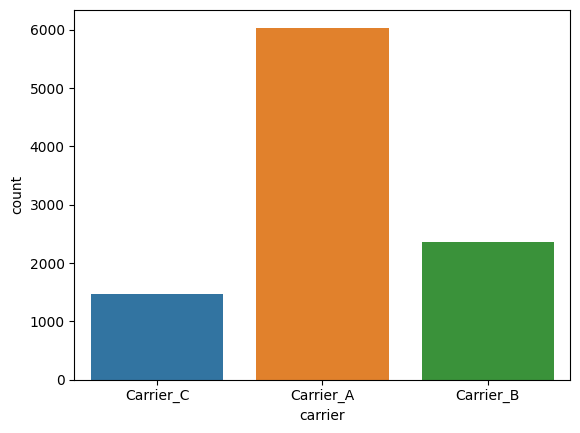

In [12]:
sns.countplot(data=master_df, x='carrier')
print(pd.value_counts(bad_df['pop_density']))

<Axes: xlabel='package_type', ylabel='count'>

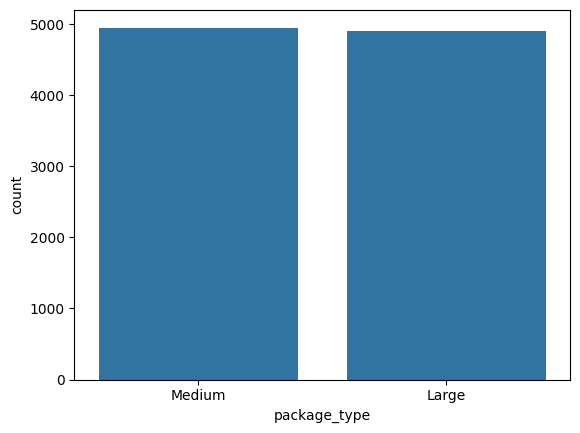

In [8]:
sns.countplot(data=master_df, x='package_type')

<Axes: xlabel='location', ylabel='count'>

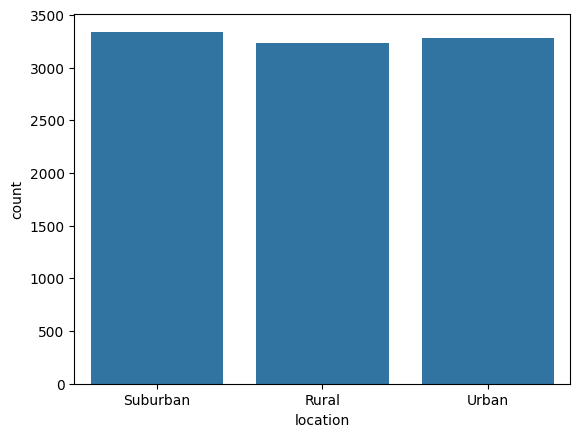

In [9]:
sns.countplot(data=master_df, x='location')

<Axes: xlabel='weather_conditions', ylabel='count'>

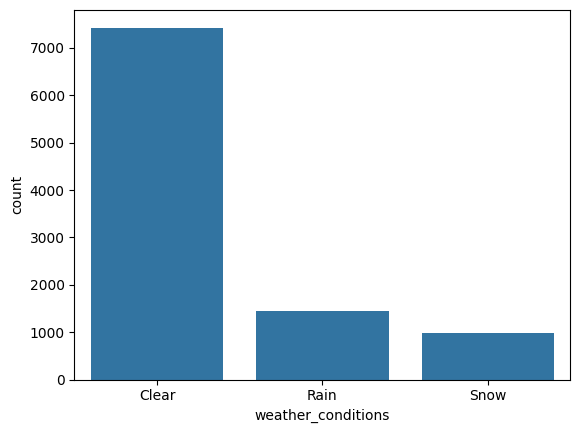

In [10]:
sns.countplot(data=master_df, x='weather_conditions')

<Axes: xlabel='shipment_issue', ylabel='count'>

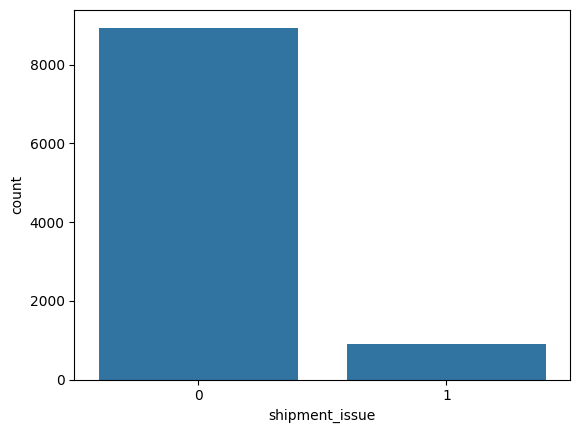

In [11]:
sns.countplot(data=master_df, x='shipment_issue')

In [114]:
bad_df = master_df[master_df['shipment_issue'] == 1]

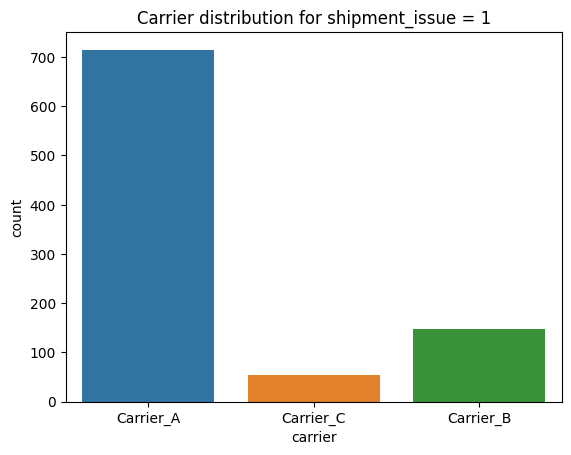

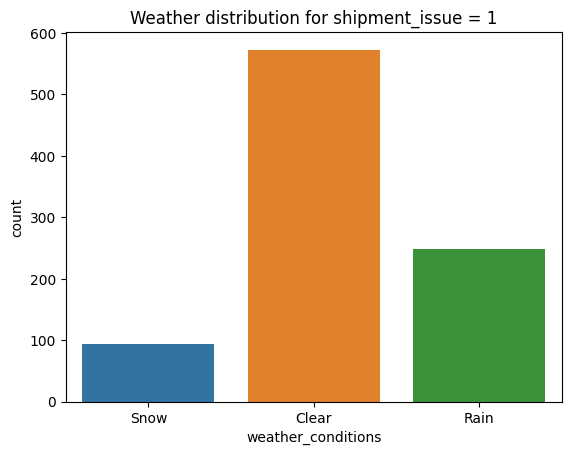

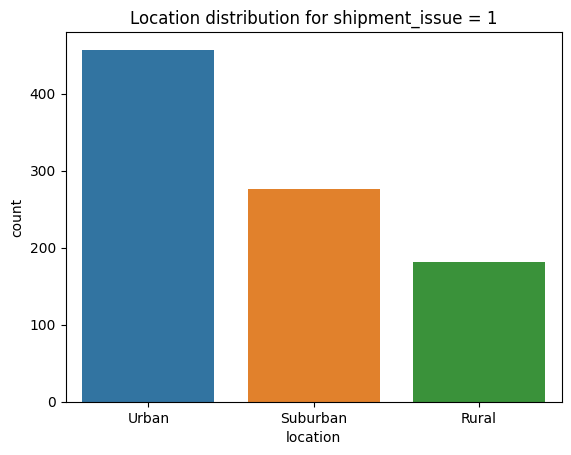

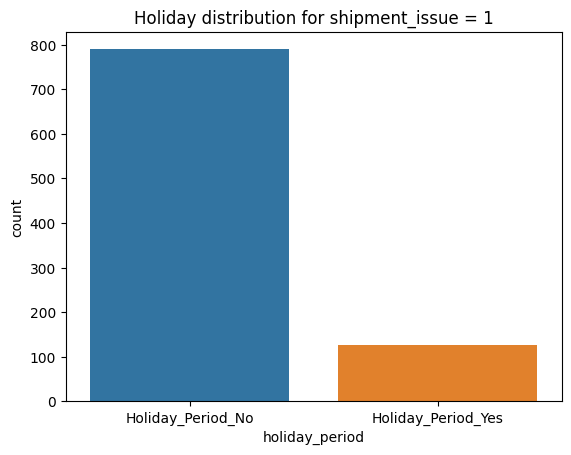

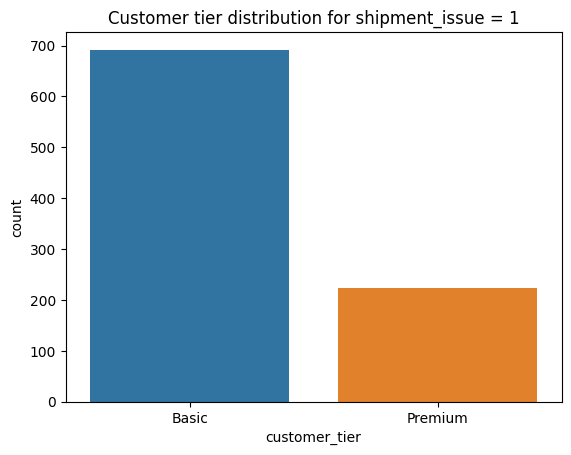

In [120]:
sns.countplot(data=bad_df, x='carrier')
plt.title('Carrier distribution for shipment_issue = 1')
plt.show()
sns.countplot(data=bad_df, x='weather_conditions')
plt.title('Weather distribution for shipment_issue = 1')
plt.show()
sns.countplot(data=bad_df, x='location')
plt.title('Location distribution for shipment_issue = 1')
plt.show()
sns.countplot(data=bad_df, x='holiday_period')
plt.title('Holiday distribution for shipment_issue = 1')
plt.show()
sns.countplot(data=bad_df, x='customer_tier')
plt.title('Customer tier distribution for shipment_issue = 1')
plt.show()



# Preparing data for training and validation

In [13]:
drop_enc = OneHotEncoder(drop='first').fit(pd.DataFrame(master_df['carrier']))
new_values = drop_enc.transform(pd.DataFrame(master_df['carrier'])).toarray()

df = master_df.drop('carrier',axis=1)
df[drop_enc.get_feature_names_out()[0]] = new_values[:,0]
df[drop_enc.get_feature_names_out()[1]] = new_values[:,1]

df['package_type'] = df['package_type'].apply(encode_size)
df['shipping_method'] = df['shipping_method'].apply(encode_shipping)
df['holiday_period'] = df['holiday_period'].apply(encode_holiday)
df['customer_tier'] = df['customer_tier'].apply(encode_customer)
df['weather_conditions'] = df['weather_conditions'].apply(encode_weather)
df['pop_density'] = df['pop_density'].apply(encode_population)
df['location'] = df['location'].apply(encode_town)

In [14]:
drop_enc = OneHotEncoder(drop='first').fit(pd.DataFrame(master_df['carrier']))
new_values = drop_enc.transform(pd.DataFrame(master_df['carrier'])).toarray()

df = master_df.drop('carrier',axis=1)
df[drop_enc.get_feature_names_out()[0]] = new_values[:,0]
df[drop_enc.get_feature_names_out()[1]] = new_values[:,1]

df['package_type'] = df['package_type'].apply(encode_size)
df['shipping_method'] = df['shipping_method'].apply(encode_shipping)
df['holiday_period'] = df['holiday_period'].apply(encode_holiday)
df['customer_tier'] = df['customer_tier'].apply(encode_customer)
df['weather_conditions'] = df['weather_conditions'].apply(encode_weather)
df['pop_density'] = df['pop_density'].apply(encode_population)
df['location'] = df['location'].apply(encode_town)

df_train_valid, df_test = train_test_split(df, test_size=.15, stratify=df['shipment_issue'])
under_sampler = RandomUnderSampler(sampling_strategy=.5, random_state=42)
X_new, y_new = under_sampler.fit_resample(df_train_valid.drop('shipment_issue',axis=1), df_train_valid['shipment_issue'])
df_train_valid = pd.concat([X_new, y_new],axis=1)

# Running two best frameworks

In [59]:
info_dict = run_RandomForest(df_train_valid, df_test)

[I 2024-10-28 18:11:13,592] A new study created in memory with name: no-name-272b983a-0c4d-4b9e-8f90-14f59a562611
[I 2024-10-28 18:11:13,811] Trial 0 finished with value: 0.5921319272125724 and parameters: {'n_estimators': 195, 'max_depth': 31, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.5921319272125724.
[I 2024-10-28 18:11:14,013] Trial 1 finished with value: 0.5921319272125724 and parameters: {'n_estimators': 180, 'max_depth': 22, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.5921319272125724.
[I 2024-10-28 18:11:14,091] Trial 2 finished with value: 0.5921319272125724 and parameters: {'n_estimators': 69, 'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.5921319272125724.
[I 2024-10-28 18:11:14,115] Trial 3 finished with value: 0.5921319272125724 and parameters: {'n_estimators': 18, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 0 with value: 

0.5835187261136333 0.5


In [25]:
info_dict_SVC = run_SVC(df_train_valid, df_test)

0.6329452338968987 0.5


In [3]:
info_dict_SVC

NameError: name 'info_dict_SVC' is not defined

In [243]:
model = info_dict_SVC['model']
cols = info_dict_SVC['cols_to_use']

export_model_and_cols(model=model, cols=cols)

# analysis

In [27]:
df = pd.read_csv('out_of_sample_predictions')

In [29]:
pd.value_counts(df['shipment_issue'], normalize=True)

/var/folders/k_/y5wzmsx1483f9z9t9tjtdj1m0000gn/T/ipykernel_89138/508110515.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df['shipment_issue'], normalize=True)


shipment_issue
0    0.9744
1    0.0256
Name: proportion, dtype: float64

In [32]:
pd.value_counts(df['shipment_issue'])

/var/folders/k_/y5wzmsx1483f9z9t9tjtdj1m0000gn/T/ipykernel_89138/1911107891.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df['shipment_issue'])


shipment_issue
0    4872
1     128
Name: count, dtype: int64

In [30]:
df_with_issue = df[df['shipment_issue'] == 1]
df_without_issue = df[df['shipment_issue'] == 0]

In [147]:
skim(df_with_issue)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 293    │ │ string      │ 8     │                                                          │
│ │ Number of columns │ 10     │ │ float64     │ 1     │                                                          │
│ └───────────────────┴────────┘ │ int64       │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name        ┃ NA  ┃ NA %   ┃ mean    ┃ sd      ┃ p0      ┃ p25     ┃ p50   ┃ p75   ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ distance           │   0 │      0 │   986.7 │   568.8 │   12.58 │   479.3 │  1009 │  1440 │  1999 │ ▇▇▆▇▆▆ │  │
│ │ shipment_issue     │   0 │      0 │       1 │       0 │       1 │       1 │     1 │     1 │     1 │     ▇  │  │
│ └────────────────────┴─────┴────────┴─────────┴─────────┴─────────┴─────────┴───────┴───────┴───────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                        ┃ NA     ┃ NA %      ┃ words per row             ┃ total words          ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ carrier                            │      0 │         0 │                         1 │                  293 │  │
│ │ shipping_method                    │      0 │         0 │                         1 │                  293 │  │
│ │ package_type                       │      0 │         0 │                         1 │                  293 │  │
│ │ location                           │      0 │         0 │                         1 │                  293 │  │
│ │ customer_tier                      │      0 │         0 │                         1 │                  293 │  │
│ │ weather_conditions                 │      0 │         0 │                         1 │                  293 │  │
│ │ holiday_period                     │      0 │         0 │                         1 │                  293 │  │
│ │ pop_density                        │      0 │         0 │                         1 │                  293 │  │
│ └────────────────────────────────────┴────────┴───────────┴───────────────────────────┴──────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [148]:
skim(df_without_issue)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 4707   │ │ string      │ 8     │                                                          │
│ │ Number of columns │ 10     │ │ float64     │ 1     │                                                          │
│ └───────────────────┴────────┘ │ int64       │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name         ┃ NA  ┃ NA %   ┃ mean   ┃ sd      ┃ p0      ┃ p25  ┃ p50     ┃ p75   ┃ p100  ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━┩  │
│ │ distance            │   0 │      0 │   1006 │   574.1 │   10.01 │  504 │   997.3 │  1505 │  2000 │ ▇▇▇▇▇▇  │  │
│ │ shipment_issue      │   0 │      0 │      0 │       0 │       0 │    0 │       0 │     0 │     0 │     ▇   │  │
│ └─────────────────────┴─────┴────────┴────────┴─────────┴─────────┴──────┴─────────┴───────┴───────┴─────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                        ┃ NA     ┃ NA %      ┃ words per row             ┃ total words          ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ carrier                            │      0 │         0 │                         1 │                 4707 │  │
│ │ shipping_method                    │      0 │         0 │                         1 │                 4707 │  │
│ │ package_type                       │      0 │         0 │                         1 │                 4707 │  │
│ │ location                           │      0 │         0 │                         1 │                 4707 │  │
│ │ customer_tier                      │      0 │         0 │                         1 │                 4707 │  │
│ │ weather_conditions                 │      0 │         0 │                         1 │                 4707 │  │
│ │ holiday_period                     │      0 │         0 │                         1 │                 4707 │  │
│ │ pop_density                        │      0 │         0 │                         1 │                 4707 │  │
│ └────────────────────────────────────┴────────┴───────────┴───────────────────────────┴──────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

<AxesSubplot: xlabel='carrier', ylabel='count'>

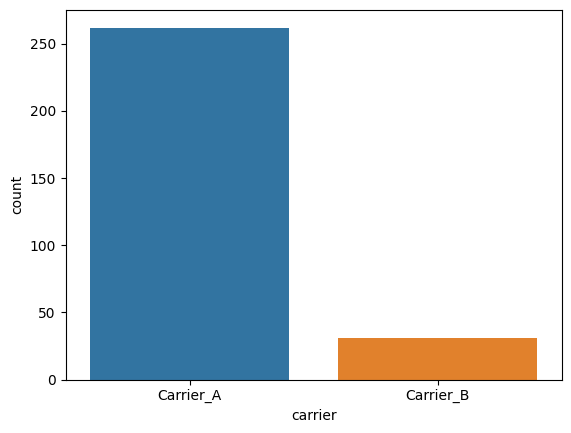

In [149]:
sns.countplot(data=df_with_issue, x='carrier')

<AxesSubplot: xlabel='holiday_period', ylabel='count'>

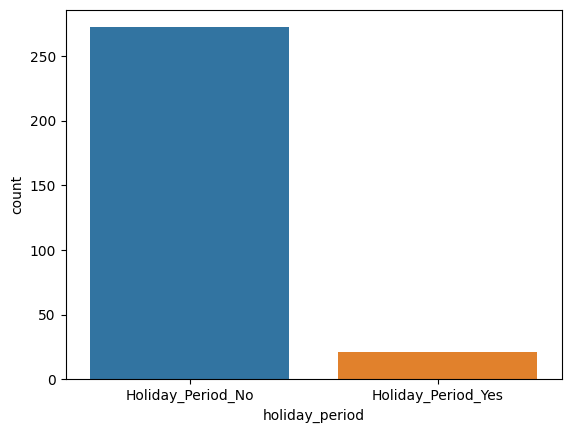

In [150]:
sns.countplot(data=df_with_issue, x='holiday_period')

<AxesSubplot: xlabel='location', ylabel='count'>

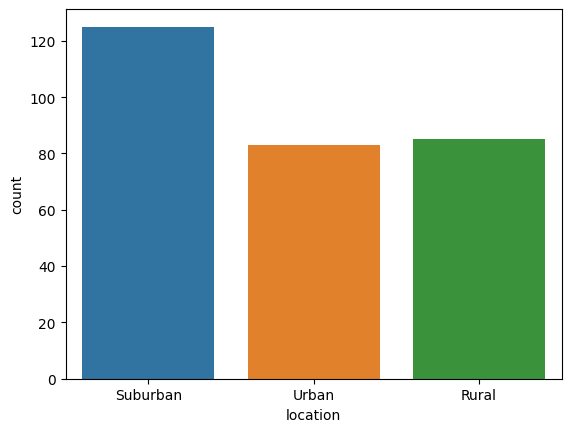

In [151]:
sns.countplot(data=df_with_issue, x='location')

<AxesSubplot: xlabel='package_type', ylabel='count'>

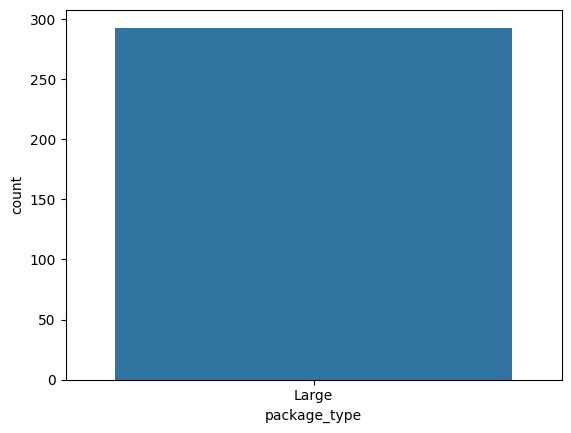

In [152]:
sns.countplot(data=df_with_issue, x='package_type')

<AxesSubplot: xlabel='shipping_method', ylabel='count'>

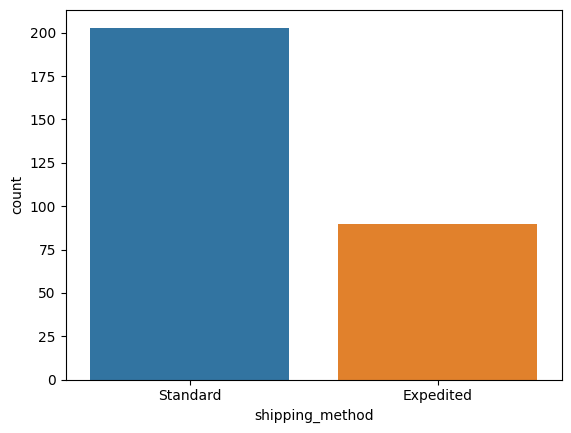

In [153]:
sns.countplot(data=df_with_issue, x='shipping_method')

<AxesSubplot: xlabel='weather_conditions', ylabel='count'>

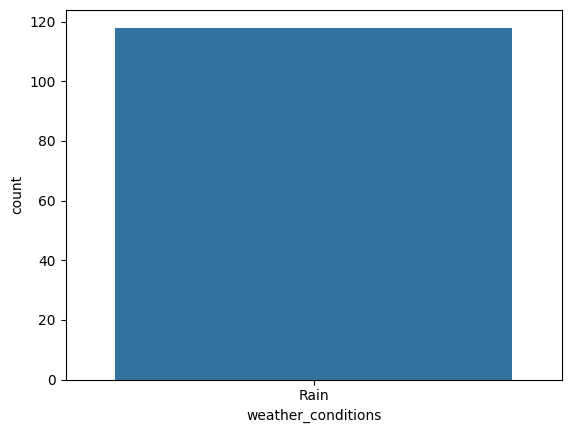

In [50]:
sns.countplot(data=df_with_issue, x='weather_conditions')

In [31]:
pd.value_counts(df_with_issue['shipping_method'], normalize=True)

/var/folders/k_/y5wzmsx1483f9z9t9tjtdj1m0000gn/T/ipykernel_89138/1365460568.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df_with_issue['shipping_method'], normalize=True)


shipping_method
Standard     0.742188
Expedited    0.257812
Name: proportion, dtype: float64